In [1]:
#All the tow truck licenses in Houston
#filter by all Houston zip codes, use Playwright
#central Houston - 77002, 77003, 77004, 77005, 77006, 77007, 77008, 77009, 77010, 77019

Scraping ZIP codes:   0%|          | 0/10 [00:00<?, ?it/s]

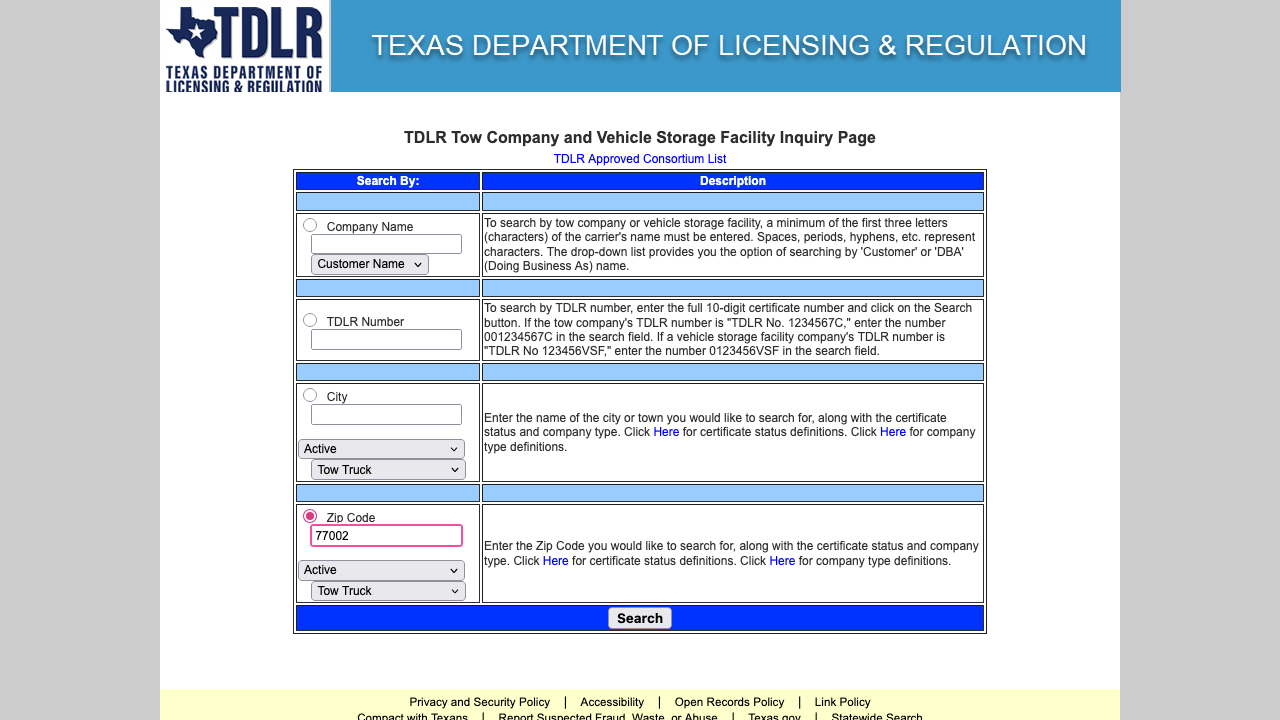

/var/folders/60/2gw19nzn43zdf99_4fqt2x6w0000gn/T/ipykernel_88899/3793352688.py:63: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  carrier_type_tag = table.find("strong", text="Carrier Type:")
/var/folders/60/2gw19nzn43zdf99_4fqt2x6w0000gn/T/ipykernel_88899/3793352688.py:65: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  num_trucks_tag = table.find("b", text="Number of Active Tow Trucks:")
/var/folders/60/2gw19nzn43zdf99_4fqt2x6w0000gn/T/ipykernel_88899/3793352688.py:68: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  mailing_tag = table.find("strong", text="Mailing:")
/var/folders/60/2gw19nzn43zdf99_4fqt2x6w0000gn/T/ipykernel_88899/3793352688.py:73: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  physical_tag = table.find("strong", text="Physical:")


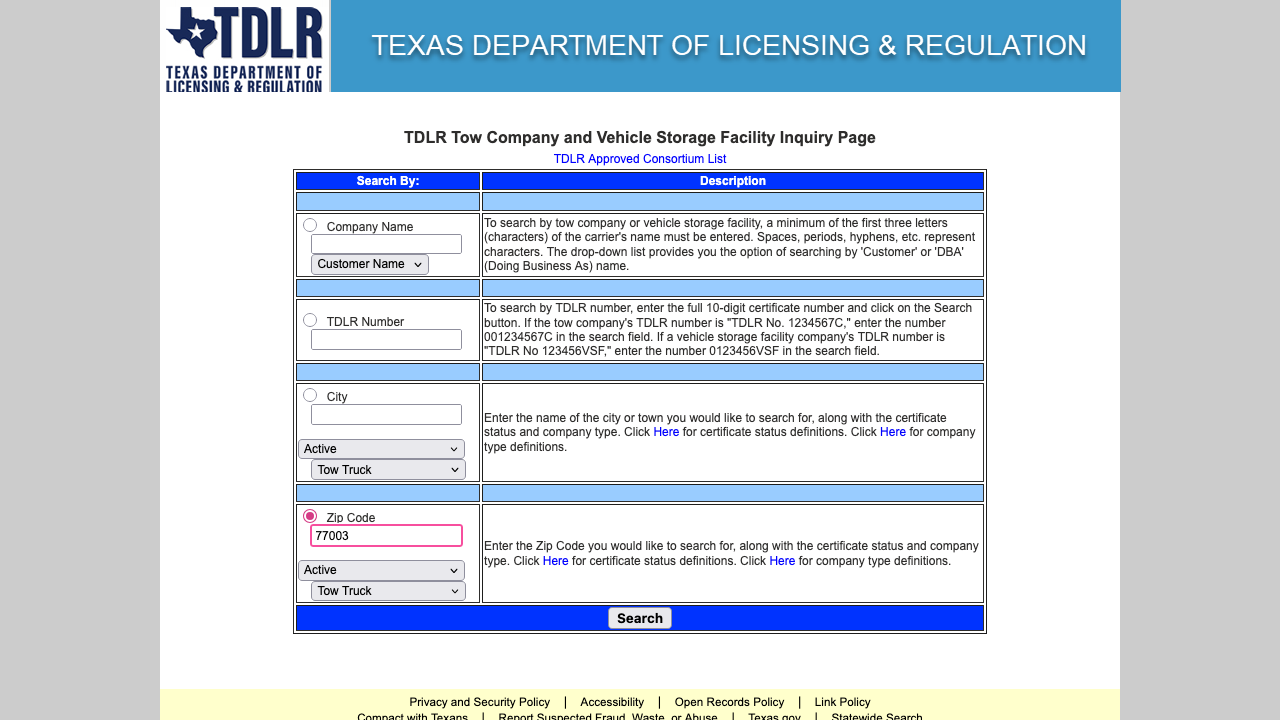

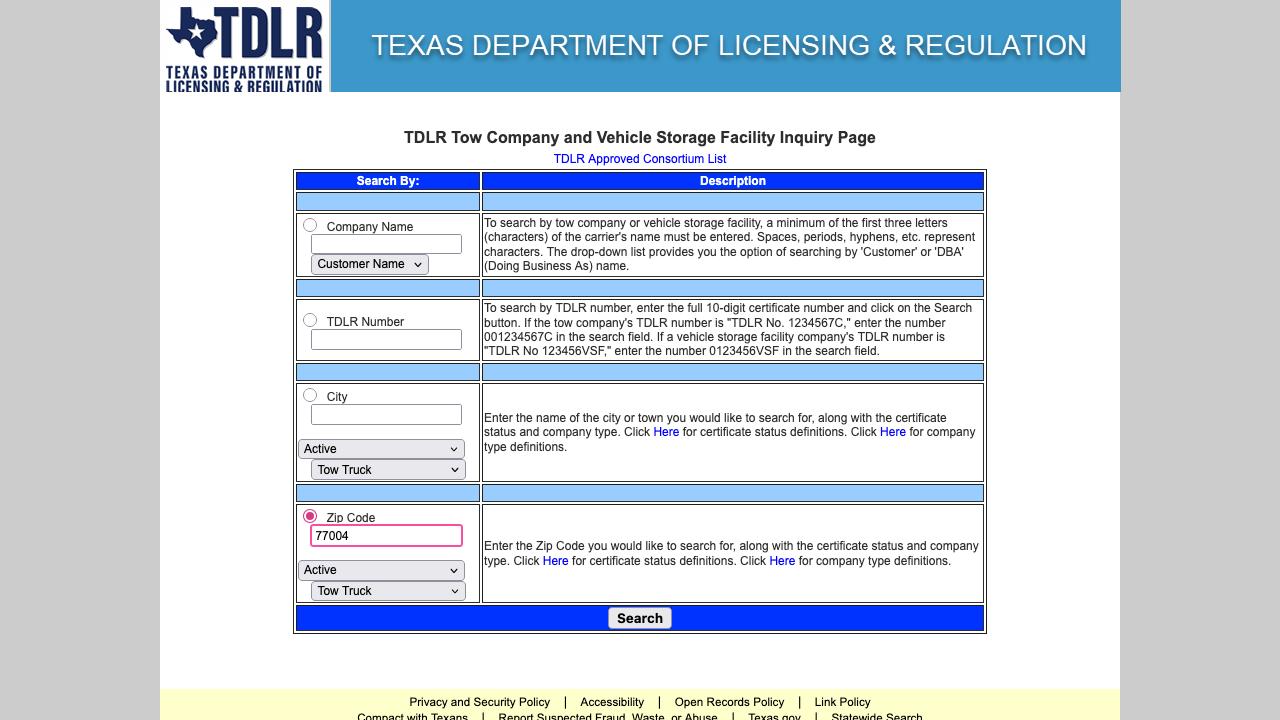

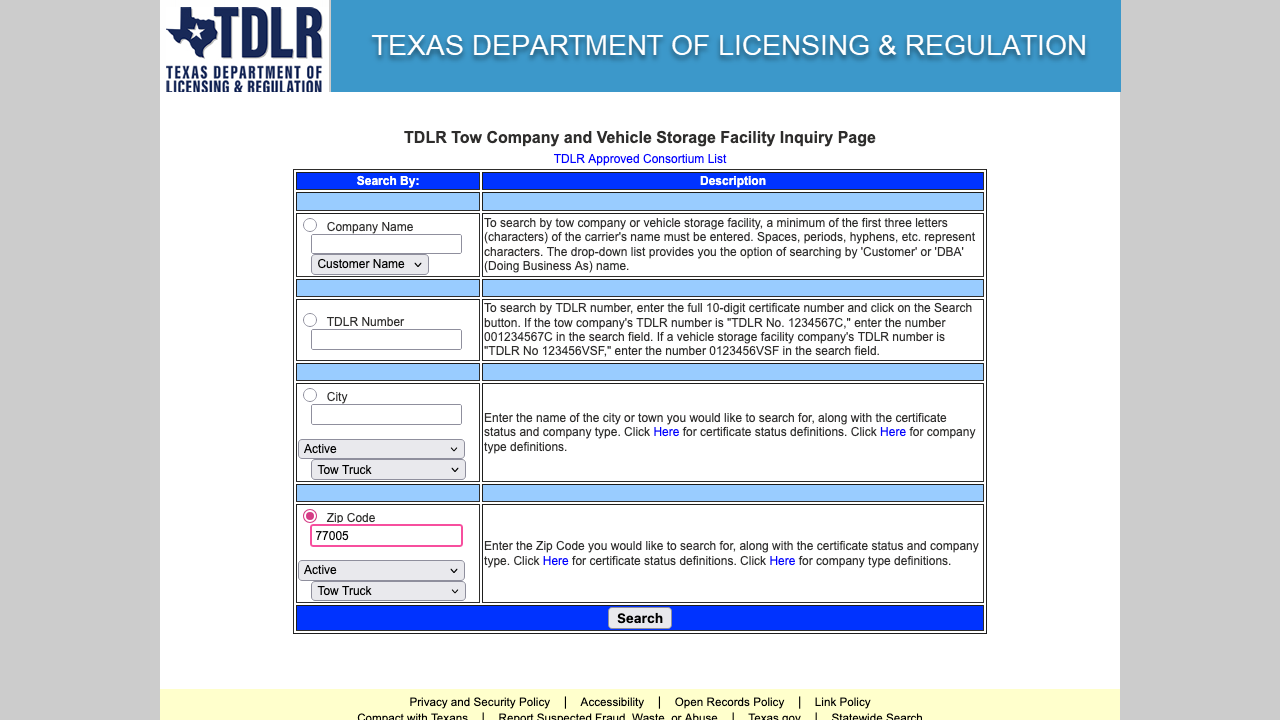

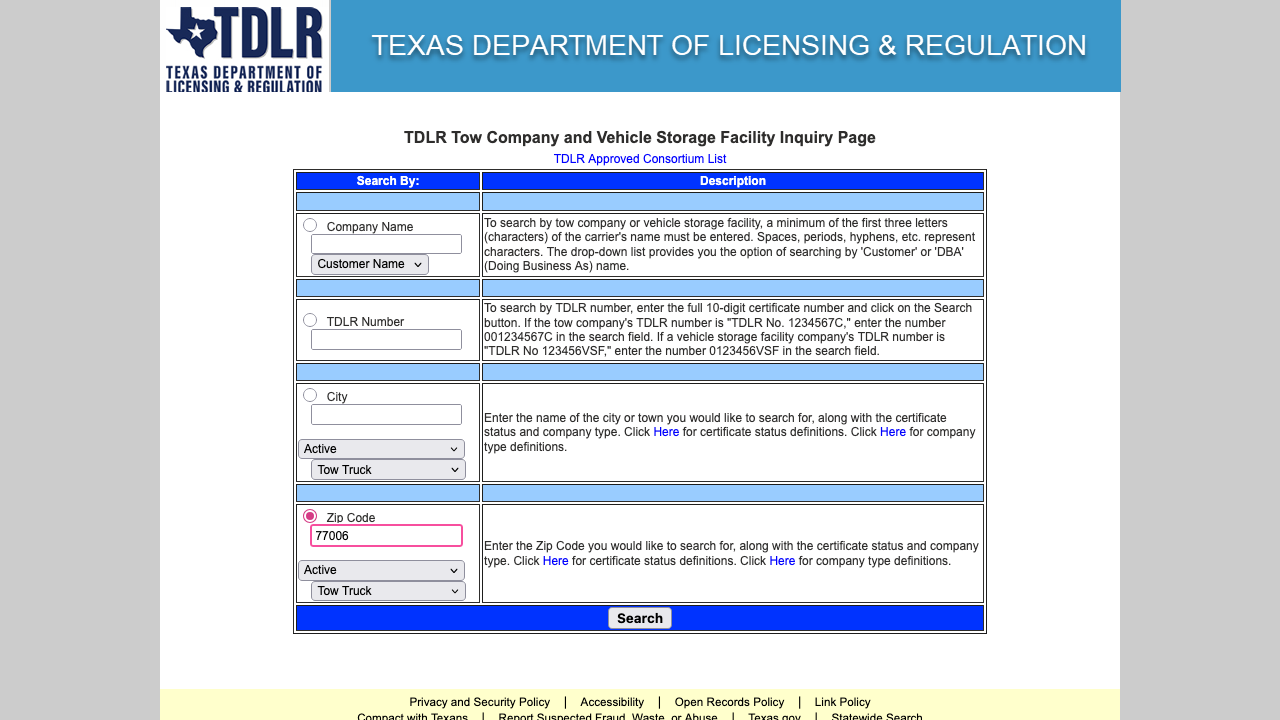

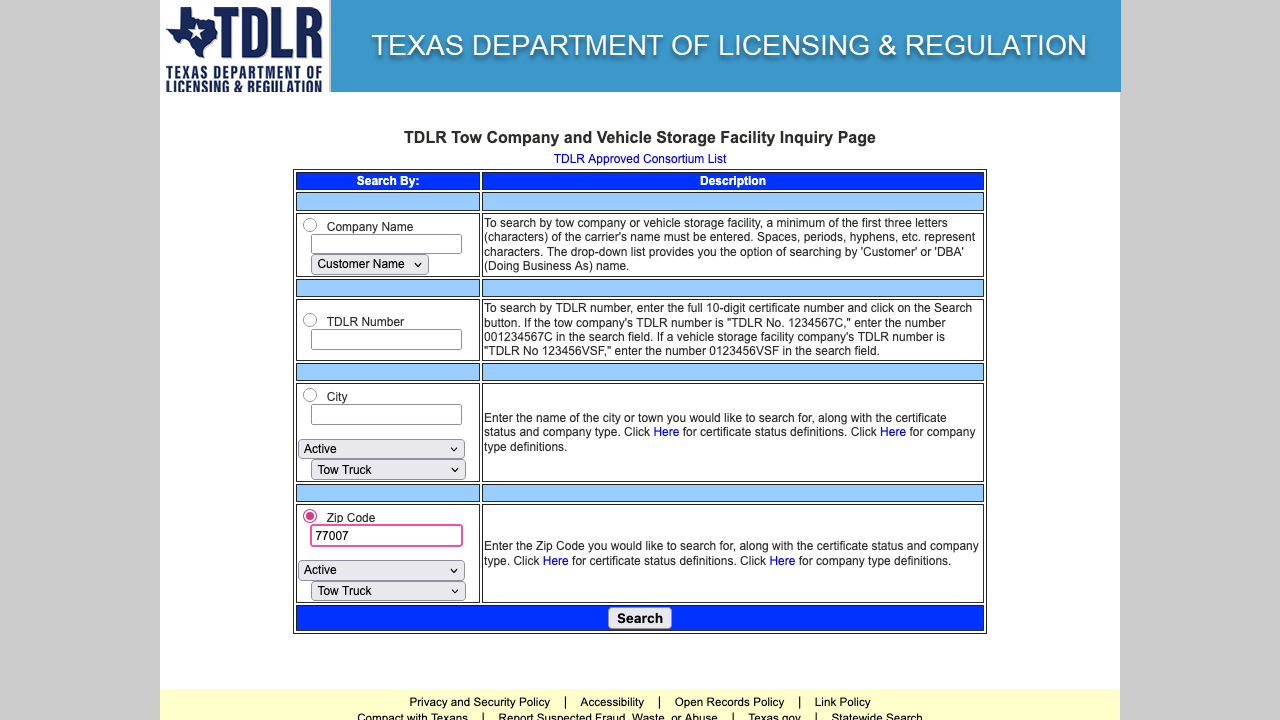

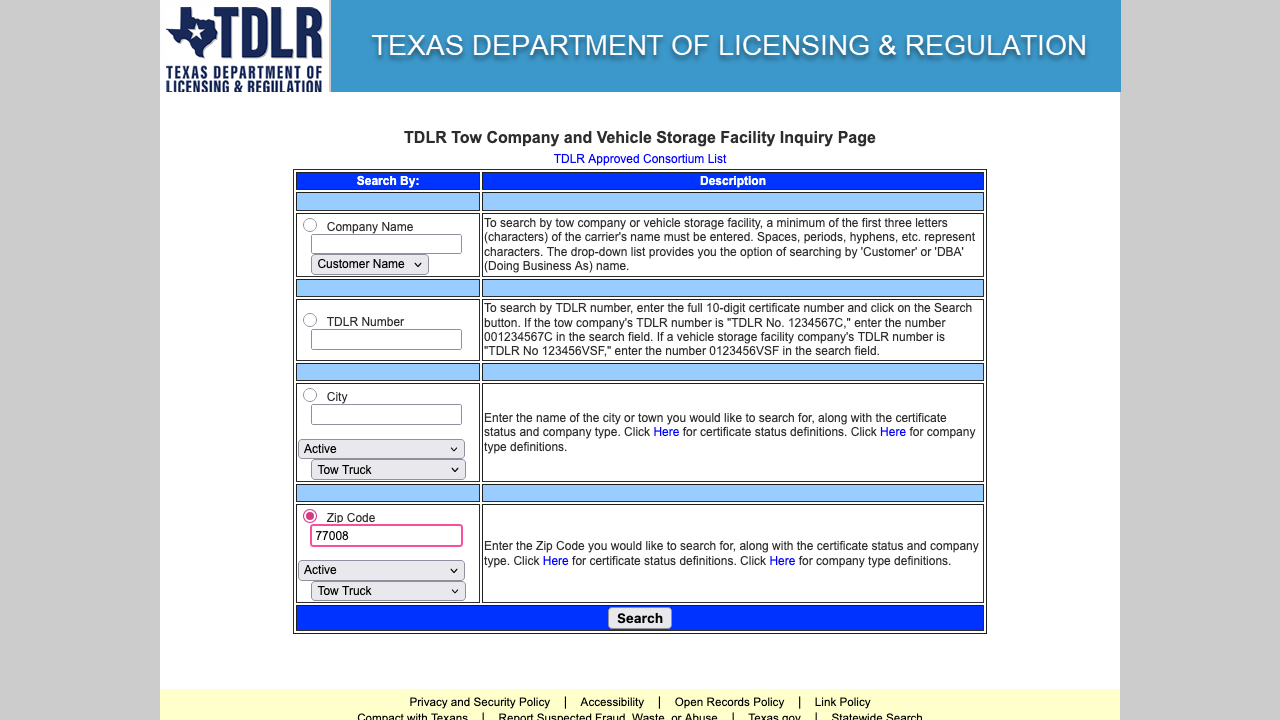

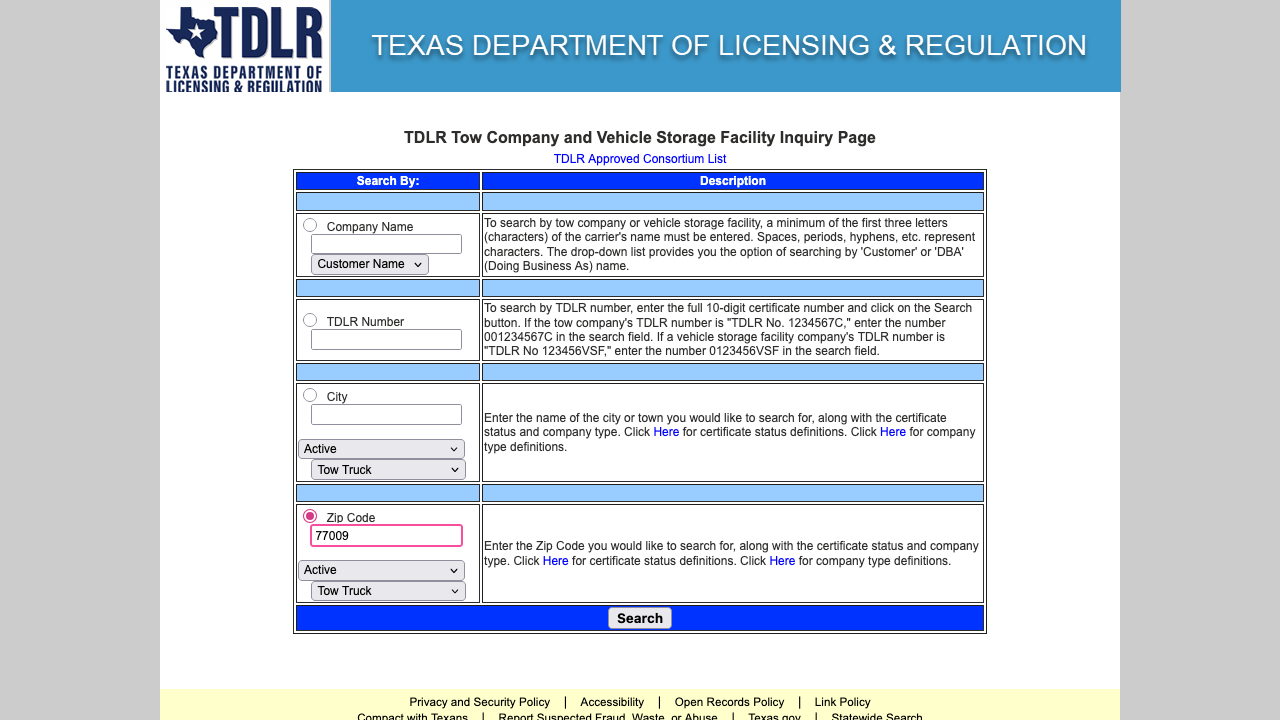

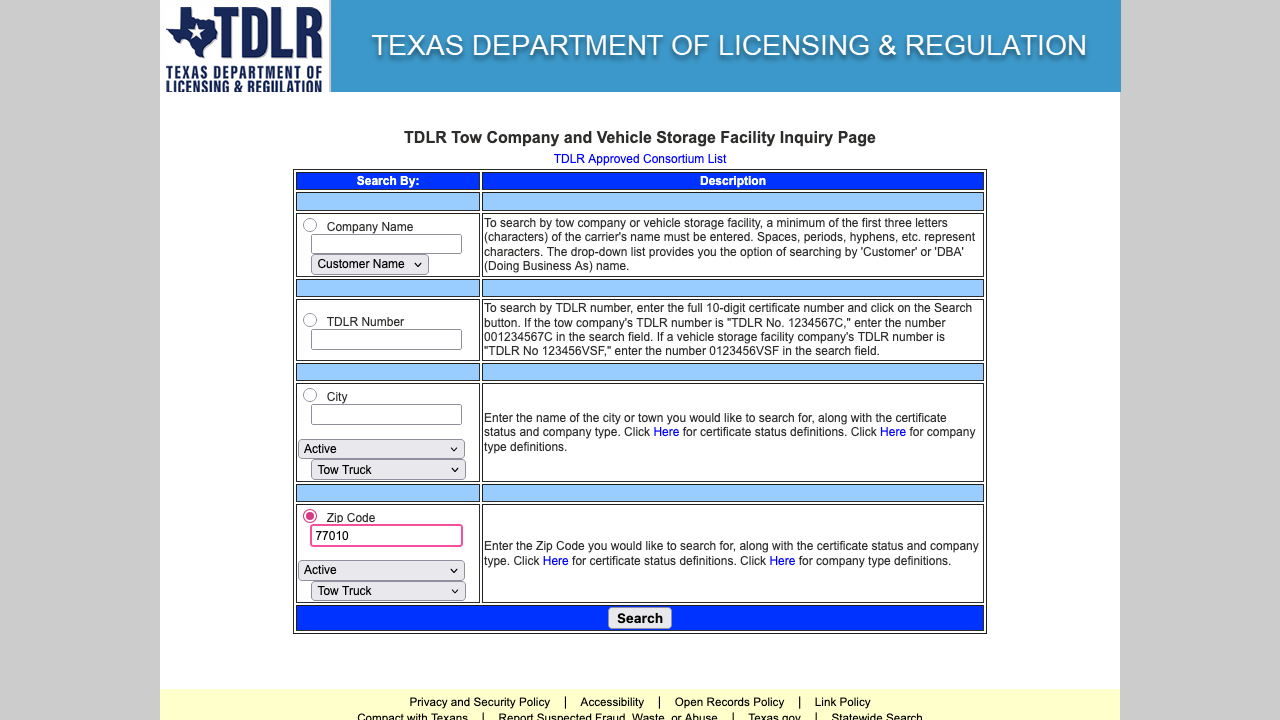

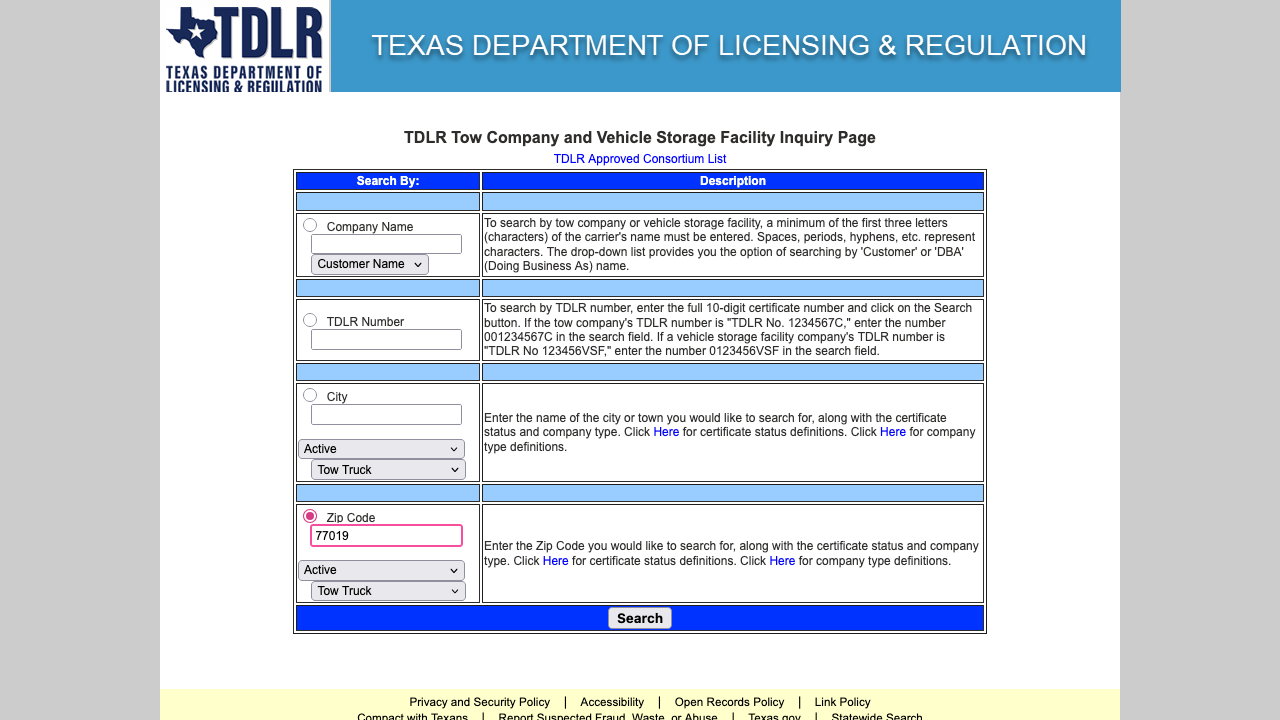

Scraping complete! CSV saved as tdlr_tow_trucks.csv


In [10]:
import asyncio
from playwright.async_api import async_playwright
from bs4 import BeautifulSoup
import pandas as pd
from IPython.display import display, Image
from tqdm.notebook import tqdm
import time

async def scrape_tow_trucks(zip_codes, delay=1):
    """
    Scrape TDLR Tow Truck data for a list of ZIP codes.
    
    Parameters:
        zip_codes (list): List of ZIP code strings.
        delay (int): Seconds to wait between ZIP code searches.
    
    Returns:
        pd.DataFrame: DataFrame of all results.
    """
    all_data = []

    async with async_playwright() as p:
        browser = await p.firefox.launch(headless=True)
        context = await browser.new_context()
        page = await context.new_page()

        for zip_code in tqdm(zip_codes, desc="Scraping ZIP codes"):
            await page.goto("https://www.tdlr.texas.gov/tools_search/", wait_until="networkidle")

            # Click Zip Code radio button
            await page.click("#zipcodebutton")

            # Fill ZIP code
            await page.fill("#zipcodedata", zip_code)

            # Select Active in status dropdown
            await page.select_option("#zip_status", value="A")

            # Select Tow Truck in carrier type dropdown
            await page.select_option("#zip_carrier_type", value="tow")

            # Submit form via JavaScript
            await page.evaluate("document.forms['searchinfo'].submit()")

            # Wait for navigation
            await page.wait_for_load_state("networkidle")

            # Screenshot preview (optional)
            screenshot_bytes = await page.screenshot()
            display(Image(data=screenshot_bytes))

            # Parse page
            html = await page.content()
            soup = BeautifulSoup(html, "html.parser")

            tables = soup.find_all("table", attrs={"border": "1"})
            if not tables:
                print(f"No results for ZIP {zip_code}")
            for table in tables:
                try:
                    cert_number = table.find("b").text.strip()
                    status = table.find_all("font")[0].text.strip()
                    carrier_type_tag = table.find("strong", text="Carrier Type:")
                    carrier_type = carrier_type_tag.next_sibling.strip() if carrier_type_tag else ""
                    num_trucks_tag = table.find("b", text="Number of Active Tow Trucks:")
                    num_trucks = num_trucks_tag.next_sibling.strip() if num_trucks_tag else ""

                    mailing_tag = table.find("strong", text="Mailing:")
                    mailing_address = ""
                    if mailing_tag:
                        mailing_address = ", ".join([line.strip() for line in mailing_tag.parent.strings if line.strip() and "Mailing:" not in line])

                    physical_tag = table.find("strong", text="Physical:")
                    physical_address = ""
                    if physical_tag:
                        physical_address = ", ".join([line.strip() for line in physical_tag.parent.strings if line.strip() and "Physical:" not in line])

                    all_data.append({
                        "ZIP Code": zip_code,
                        "Certificate Number": cert_number,
                        "Status": status,
                        "Carrier Type": carrier_type,
                        "Number of Active Tow Trucks": num_trucks,
                        "Mailing Address": mailing_address,
                        "Physical Address": physical_address
                    })
                except Exception as e:
                    print(f"Error parsing row for ZIP {zip_code}: {e}")

            # Small delay between searches
            time.sleep(delay)

        await browser.close()

    df = pd.DataFrame(all_data)
    return df

# Example usage
zip_codes = ["77002", "77003", "77004", "77005", "77006", "77007", "77008", "77009", "77010", "77019"]
df_results = await scrape_tow_trucks(zip_codes, delay=2)  # 2-second delay between ZIP codes

# Preview results
df_results.head()

# Save to CSV
df_results.to_csv("tdlr_tow_trucks.csv", index=False)
print("Scraping complete! CSV saved as tdlr_tow_trucks.csv")
